**Google Colab Required. Google Colab Pro Preferred.**

In [1]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.6 MB 13.4 MB/s 
     |████████████████████████████████| 3.3 MB 66.6 MB/s 
     |████████████████████████████████| 895 kB 59.8 MB/s 
     |████████████████████████████████| 636 kB 56.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 542 kB 12.8 MB/s 
     |████████████████████████████████| 76 kB 4.0 MB/s 
     |████████████████████████████████| 118 kB 31.1 MB/s 
     |████████████████████████████████| 243 kB 24.8 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
root_dir = "gdrive/MyDrive/Capstone/"

pretrained = "albert-base-v2"
model_checkpoint = pretrained
tokenizer_checkpoint = pretrained

num_labels = 10
batch_size = 16

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AdamW, get_scheduler

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, load_metric, load_from_disk

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

import pickle
from tqdm.auto import tqdm

In [5]:
dataset = load_dataset('csv', data_files=root_dir + 'df_cleaned.csv', split='train')

Using custom data configuration default-863e501dda6703d2


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-863e501dda6703d2/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


In [6]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["tweet_text_cleaned"], padding="max_length", truncation=True)

tokenized_datasets = dataset.train_test_split(test_size=0.1).map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(['class_label', 
                                                        'data_type', 
                                                        'event',
                                                        'event_type',
                                                        'file_name',
                                                        'hashtags',
                                                        'processed_text_length',
                                                        #'token_type_ids',
                                                        'tweet_id',
                                                        'tweet_text',
                                                        'tweet_text_cleaned',
                                                        'year'])
tokenized_datasets = tokenized_datasets.rename_column("class_label_id", "labels")
tokenized_datasets.set_format("torch")

In [8]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=batch_size)

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [10]:
device

device(type='cuda')

In [11]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [12]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/189 [00:00<?, ?it/s]

In [13]:
metric= load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

{'accuracy': 0.665}

In [14]:
metric_name = "accuracy"

args = TrainingArguments(
    "capstone_"+pretrained,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model=metric_name,
)

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

***** Running training *****
  Num examples = 68834
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 12909


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.681000,0.688058,0.754086
2,0.575800,0.658119,0.759053
3,0.458300,0.667633,0.766505


Saving model checkpoint to capstone_albert-base-v2/checkpoint-500
Configuration saved in capstone_albert-base-v2/checkpoint-500/config.json
Model weights saved in capstone_albert-base-v2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in capstone_albert-base-v2/checkpoint-500/tokenizer_config.json
Special tokens file saved in capstone_albert-base-v2/checkpoint-500/special_tokens_map.json
Saving model checkpoint to capstone_albert-base-v2/checkpoint-1000
Configuration saved in capstone_albert-base-v2/checkpoint-1000/config.json
Model weights saved in capstone_albert-base-v2/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in capstone_albert-base-v2/checkpoint-1000/tokenizer_config.json
Special tokens file saved in capstone_albert-base-v2/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to capstone_albert-base-v2/checkpoint-1500
Configuration saved in capstone_albert-base-v2/checkpoint-1500/config.json
Model weights saved in capstone_albert-base-v

TrainOutput(global_step=12909, training_loss=0.6059771198021819, metrics={'train_runtime': 6849.5163, 'train_samples_per_second': 30.148, 'train_steps_per_second': 1.885, 'total_flos': 4938908479377408.0, 'train_loss': 0.6059771198021819, 'epoch': 3.0})

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 7649
  Batch size = 16


{'epoch': 3.0,
 'eval_accuracy': 0.766505425545823,
 'eval_loss': 0.6676325798034668,
 'eval_runtime': 89.9143,
 'eval_samples_per_second': 85.07,
 'eval_steps_per_second': 5.327}

In [19]:
model.save_pretrained(root_dir + 'models/' + pretrained)
tokenizer.save_pretrained(root_dir + 'tokenizers/' + pretrained)

Configuration saved in gdrive/MyDrive/Capstone/models/albert-base-v2/config.json
Model weights saved in gdrive/MyDrive/Capstone/models/albert-base-v2/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/Capstone/tokenizers/albert-base-v2/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/Capstone/tokenizers/albert-base-v2/special_tokens_map.json


('gdrive/MyDrive/Capstone/tokenizers/albert-base-v2/tokenizer_config.json',
 'gdrive/MyDrive/Capstone/tokenizers/albert-base-v2/special_tokens_map.json',
 'gdrive/MyDrive/Capstone/tokenizers/albert-base-v2/tokenizer.json')

In [20]:
tokenized_datasets.save_to_disk(root_dir + 'assets/datasets/' + pretrained)

# Results Visualization

In [21]:
dataset = load_dataset('csv', data_files=root_dir + 'df_cleaned.csv', split='train')
tokenized_datasets = load_from_disk(root_dir + 'assets/datasets/' + pretrained)
tokenized_datasets.set_format("torch")

Using custom data configuration default-863e501dda6703d2
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-863e501dda6703d2/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


In [22]:
model_checkpoint = root_dir + "models/" + pretrained
tokenizer_checkpoint = root_dir + "tokenizers/" + pretrained

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=10)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

loading configuration file gdrive/MyDrive/Capstone/models/albert-base-v2/config.json
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [23]:
device

device(type='cuda')

In [24]:
metric = load_metric("accuracy")
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=batch_size)

model.eval()
#prob = []
y_pred = []
total_loss = 0.0
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    total_loss += outputs.loss.item()
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    #prob.extend(torch.nn.Softmax(dim=1)(outputs.logits))
    y_pred.extend([t.item() for t in predictions])

loss = total_loss/tokenized_datasets["test"].shape[0]
metric.compute()

{'accuracy': 0.766505425545823}

In [25]:
y_true = tokenized_datasets["test"]["labels"].numpy().tolist()

In [26]:
assert len(y_true) == len(y_pred)

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, path='cm', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     pickle.dump(cm, open(path, 'wb'))

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [28]:
label_name = sorted(pd.Series(dataset['class_label']).unique())

loss: 0.04
accuracy: 0.77
matthews coef: 0.72
precision score for caution_and_advice: 0.89
recall score for caution_and_advice: 0.86
f1 score for caution_and_advice: 0.87
precision score for displaced_people_and_evacuations: 0.60
recall score for displaced_people_and_evacuations: 0.57
f1 score for displaced_people_and_evacuations: 0.58
precision score for infrastructure_and_utility_damage: 0.92
recall score for infrastructure_and_utility_damage: 0.93
f1 score for infrastructure_and_utility_damage: 0.93
precision score for injured_or_dead_people: 0.79
recall score for injured_or_dead_people: 0.82
f1 score for injured_or_dead_people: 0.81
precision score for missing_or_found_people: 0.56
recall score for missing_or_found_people: 0.52
f1 score for missing_or_found_people: 0.54
precision score for not_humanitarian: 0.83
recall score for not_humanitarian: 0.90
f1 score for not_humanitarian: 0.87
precision score for other_relevant_information: 0.87
recall score for other_relevant_information

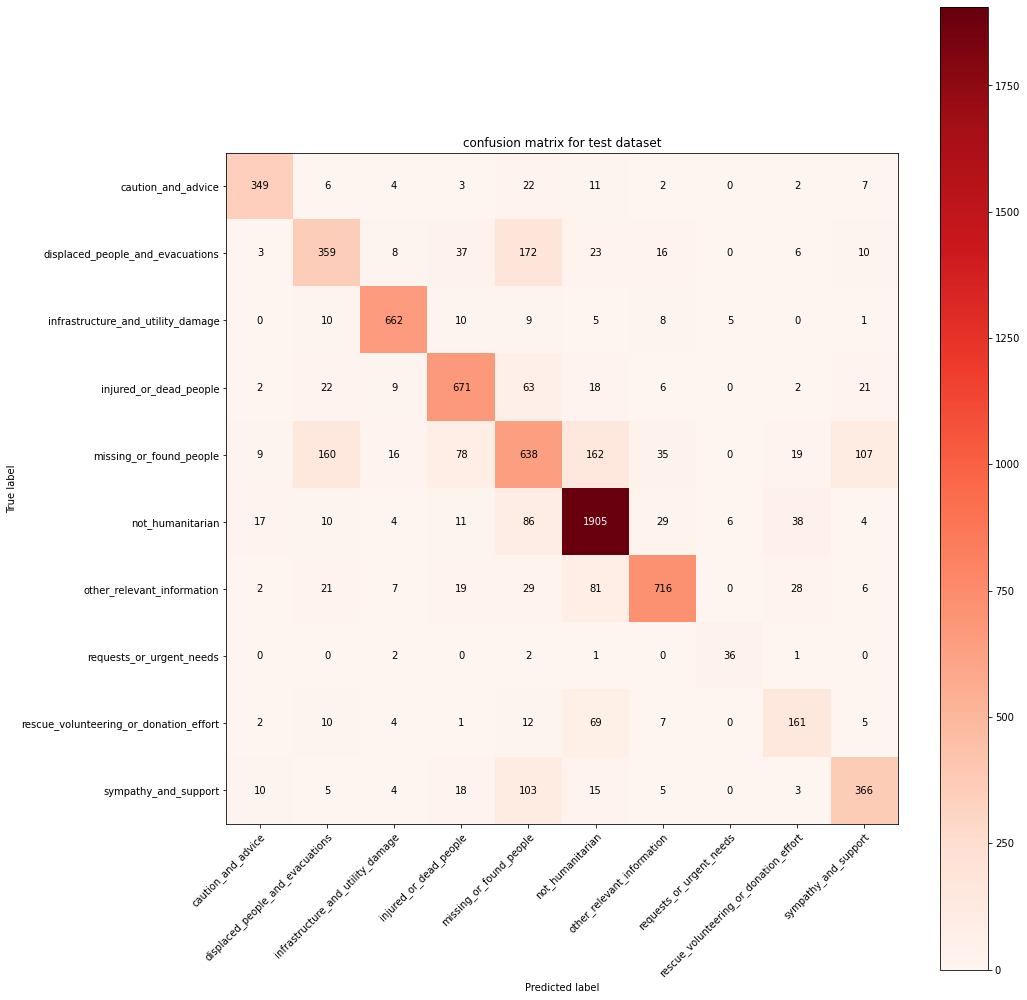

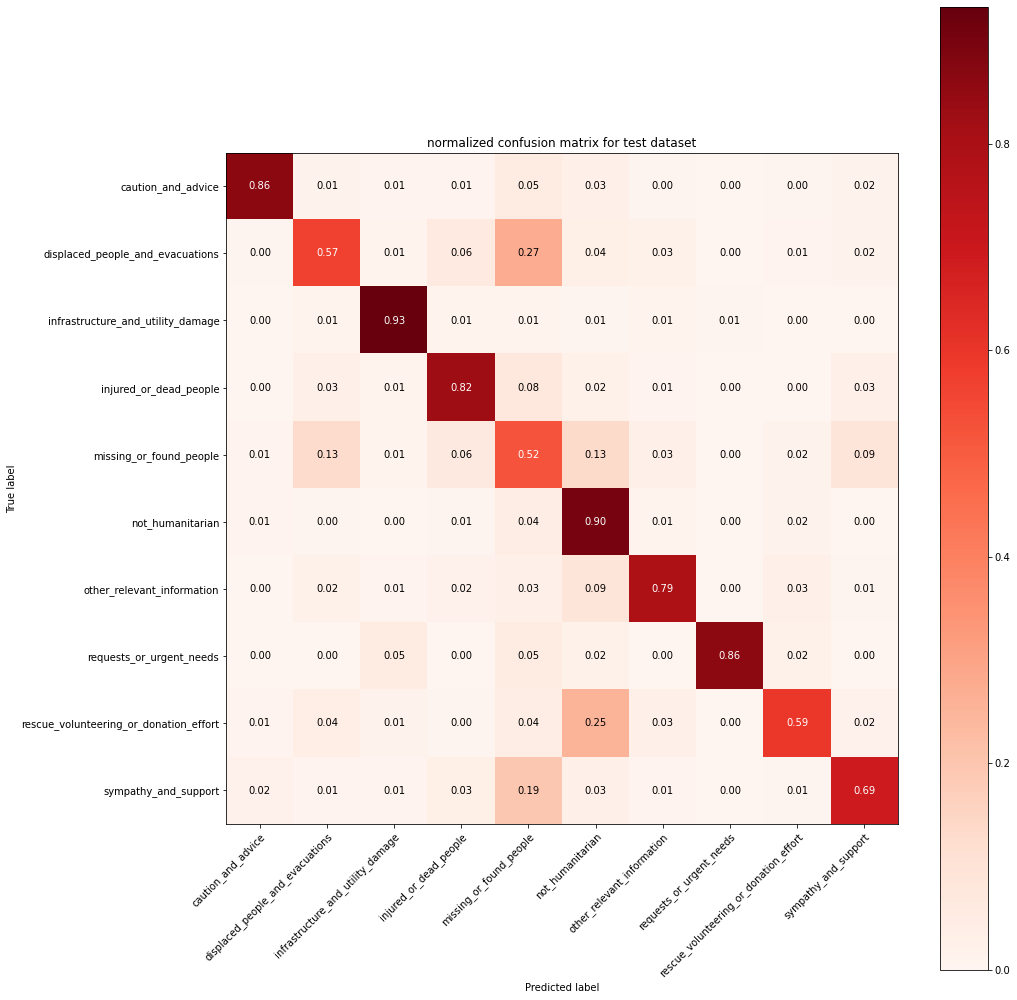

In [29]:
accuracy = accuracy_score(y_true, y_pred)
matthews = matthews_corrcoef(y_true, y_pred)

precisions = {}
recalls = {}
f1s = {}
aucrocs = {}

for i in range(len(label_name)):
    prediction_ = [1 if pred == i else 0 for pred in y_pred]
    true_ = [1 if label == i else 0 for label in y_true]
    f1s.update({label_name[i]: f1_score(true_, prediction_)})
    precisions.update({label_name[i]: precision_score(true_, prediction_)})
    recalls.update({label_name[i]: recall_score(true_, prediction_)})
    # aucrocs.update({label_name[i]: roc_auc_score(true_, list(t.item() for t in prob[:, i]))})

metrics_dict = {'loss': loss, 'accuracy': accuracy, 'matthews coef': matthews, 'precision': precisions,
                     'recall': recalls, 'f1': f1s, 
                # 'aucroc': aucrocs
                }

pickle.dump(metrics_dict, open(root_dir+'/output/evaluation_metrics/'+pretrained, 'wb'))

cm = plot_confusion_matrix(y_true, y_pred, label_name, normalize=False,
                      path='test_confusion_matrix', title='confusion matrix for test dataset')
plt.savefig(root_dir+'/output/confusion_matrix/'+pretrained, format='png')
cm_norm = plot_confusion_matrix(y_true, y_pred, label_name, normalize=True,
                      path='test normalized_confusion_matrix', title='normalized confusion matrix for test dataset')
plt.savefig(root_dir+'/output/normalized_confusion_matrix/'+pretrained, format='png')

print('loss: %.2f' % loss)
print('accuracy: %.2f' % accuracy)
print('matthews coef: %.2f' % matthews)
for i in range(len(label_name)):
    print('precision score for %s: %.2f' % (label_name[i], precisions[label_name[i]]))
    print('recall score for %s: %.2f' % (label_name[i], recalls[label_name[i]]))
    print('f1 score for %s: %.2f' % (label_name[i], f1s[label_name[i]]))
    # print('auc roc score for %s: %.2f' % (label_name[i], aucrocs[label_name[i]]))

In [ ]:
with open(root_dir+'/output/evaluation_metrics/'+pretrained, 'rb') as file:
    p = pickle.load(file)